# Simple audio recognition: Recognizing keywords
In this notebook, I will go over how to build a basic speech recognition network that will recognize "down", "go", "left", "no", "right", "stop", "up" and "yes". This dataset is similar to the MNIST dataset in that it is a basic dataset with a limited number of classes. In the MNIST dataset there were only 10 digits and in the portion of the dataset we will download, there are 30 words but we will only be using a portion of this dataset. We will be using a CNN to create the model.

## Setup

Import necessary modules and dependencies.

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the Speech Commands dataset
This will download a portion of the following dataset [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands). The original dataset consists of over 105,000 WAV audio files of people saying thirty different words. This datasets primary goal was to allow small models to detect specific spoken words from a set of ten target words while limiting the number of false positives from background noise.

In [2]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182083584/182082353 [==============================] - 1s 0us/step


The following cell shows what words are labelled in the smaller dataset that we downloaded.

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)


Commands: ['stop' 'right' 'down' 'go' 'left' 'yes' 'up' 'no']


Extract the audio files into a list and shuffle it.

In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/yes/c0445658_nohash_0.wav', shape=(), dtype=string)


Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.

In [5]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [6]:
#what each training file looks like
train_files[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'data/mini_speech_commands/yes/c0445658_nohash_0.wav'>

## Reading audio files and their labels

The audio file will initially be read as a binary file, which will be converted into a tensor.

The command, `tf.audio.decode_wav`, will return the WAV-encoded audio as a Tensor and the sample rate.

A WAV file contains time series data with a set number of samples per second. 

Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system, like the files in `mini_speech_commands`, the values range from -32768 to 32767. 
The sample rate for this dataset is 16kHz.
Note that `tf.audio.decode_wav` will normalize the values to the range [-1.0, 1.0].

In [7]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

The label for each WAV file is its parent directory.

In [8]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  #index of label
  return parts[-2] 

Now we can see the labels in our training data

In [9]:
get_label(train_files[0]).numpy()

b'yes'

Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [10]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

We will now apply `process_path` to build our training set to extract the audio-label pairs and check the results. 

We will later build the validation and test sets using a similar procedure later on.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Let's examine a few audio waveforms with their corresponding labels.

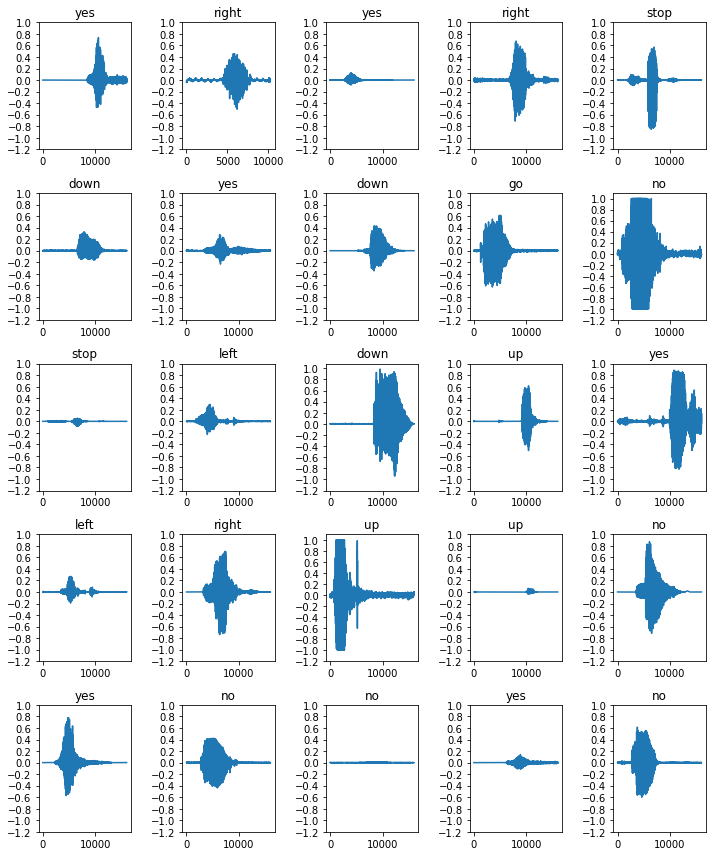

In [12]:
rows = 5
cols = 5
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)
fig.tight_layout()
plt.show()

Interesting to see that even some of the same words have plots that look almost nothing alike.

## Spectrogram

In the following cells, we convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform to convert the audio into the time-frequency domain. In simple English, a spectrogram shows the frequencies that make up the sound, from low to high, and how they change over time, from left to right. 

A Fourier transform ([`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but loses all time information. The STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that we can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, we'll only need the magnitude for this tutorial, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`. 

Wee also want the waveforms to have the same length, so that when we convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.


In [13]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

Next, we will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.

In [14]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


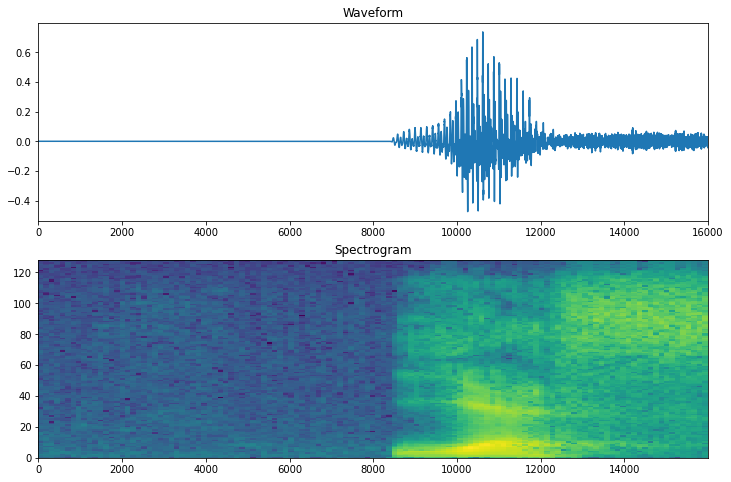

In [15]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [16]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [17]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

The following will show a 5x5 output of spectrograms of different audios along with the relevant labels.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


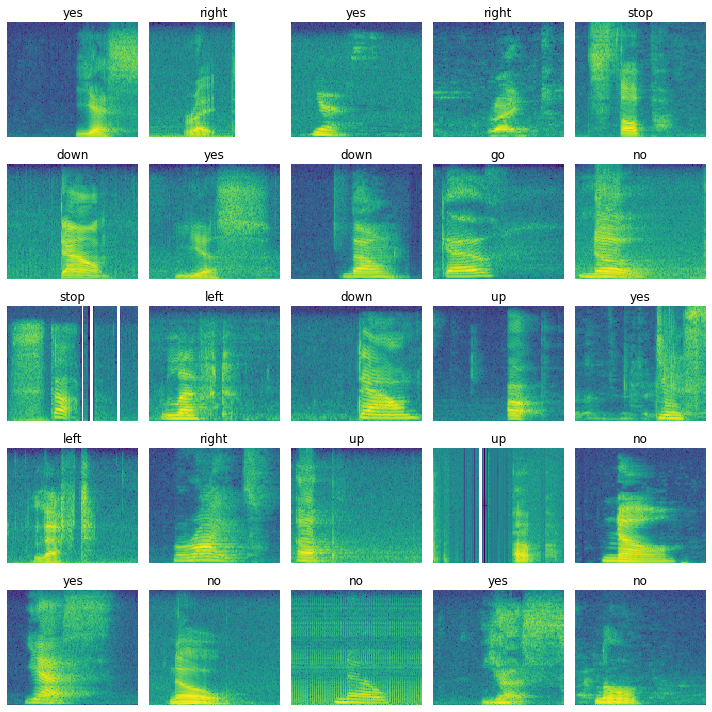

In [18]:
rows = 5
cols = 5
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
fig.tight_layout()
plt.show()

It is interesting to see why some of the spectrograms are not filling the full square. I am unsure as to why this is happening.

## Build and train the model

Now we can build and train our model. But before we do that, we'll need to repeat the training set preprocessing on the validation and test sets.

In [19]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [20]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training.

In [21]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.

In [22]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, we'll use a simple convolutional neural network, since we have transformed the audio files into spectrogram images.
The model also has the following additional preprocessing layers:


A Resizing layer to downsample the input to enable the model to train faster.


A Normalization layer to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [23]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

We will use the SparseCategoricalCrossentropy loss function because there are more than two label classes.

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

I found that using 100 epochs is significantly better than 50 but not much changed afterwards so I didn't push it further.

In [25]:
EPOCHS = 100
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100
100/100 [==============================] - 47s 150ms/step - loss: 1.9273 - accuracy: 0.2728 - val_loss: 1.3473 - val_accuracy: 0.5788
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 1.2845 - accuracy: 0.5428 - val_loss: 0.9562 - val_accuracy: 0.7100
Epoch 3/100
100/100 [==============================] - 1s 7ms/step - loss: 0.9441 - accuracy: 0.6623 - val_loss: 0.7884 - val_accuracy: 0.7312
Epoch 4/100
100/100 [==============================] - 1s 7ms/step - loss: 0.7806 - accuracy: 0.7182 - val_loss: 0.7157 - val_accuracy: 0.7650
Epoch 5/100
100/100 [==============================] - 1s 7ms/step - loss: 0.6748 - accuracy: 0.7668 - val_loss: 0.6655 - val_accuracy: 0.7738
Epoch 6/100
100/100 [==============================] - 1s 7ms/step - loss: 0.5809 - accuracy: 0.7967 - val_loss: 0.6421 - val_accuracy: 0.7900
Epoch 7/100
100/100 [==============================] - 1s 7ms/step - loss: 0.5255 - accuracy: 0.8135 - val_loss: 0.5832 - val_accuracy: 0.8

Let's check the training and validation loss curves to see how our model has improved during training.

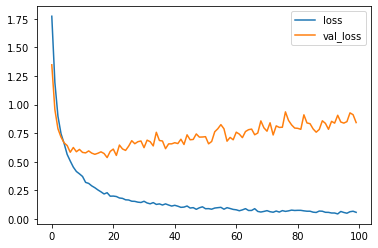

In [26]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

It seems like after ~10 epochs the valuation loss stops decreasing and even starts to increase. The loss decreases to nearly 0 though.

## Evaluate test set performance

Let's run the model on the test set and check performance.

In [27]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [28]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 88%


For this specific output, I got an accuracy of 88%. This seems like a pretty good accuracy for the simplicity of the model but obviously with more different words, the accuracy would decrease.

### Display a confusion matrix

A confusion matrix shows how the model classifies certain entries, meaning we can easily see which entries are misclassified into others or correctly classified. Darker squares represent few classifications and orange/lighter squares are more common classifications.

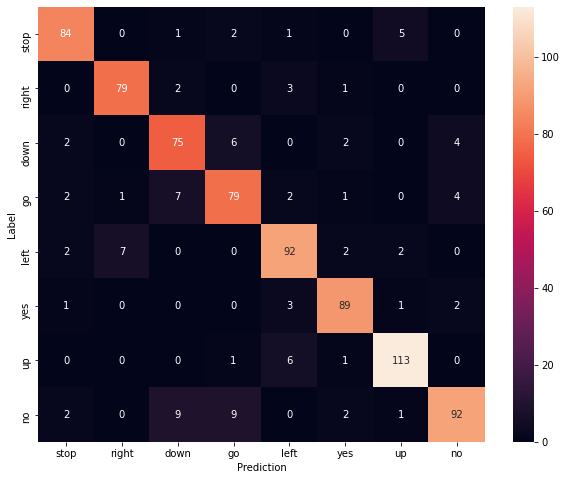

In [29]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no." How well does our model perform?

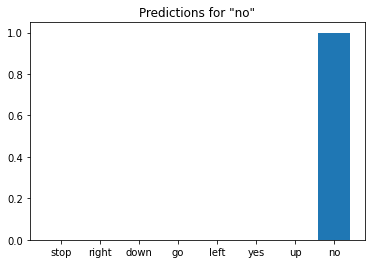

In [30]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

While the output above shows that the model classified this audio of "no" perfectly, in previous runnings when I did not have as many epochs as 100, the model would often mistake this "no" with "go" (which makes sense intuitively). This can also be shown in the confusion matrix that the two words "no" and "go" are often mis-classified.

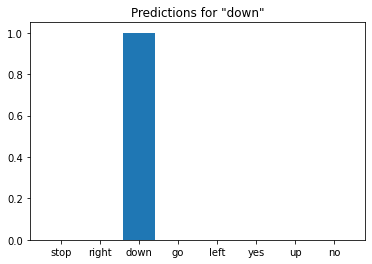

In [31]:
sample_file = data_dir/'down/004ae714_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

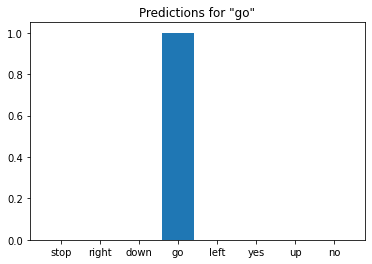

In [32]:
sample_file = data_dir/'go/004ae714_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

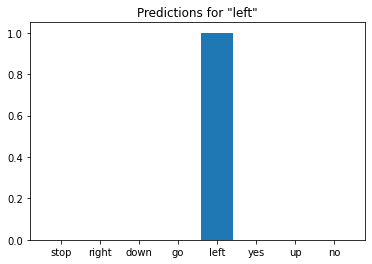

In [33]:
sample_file = data_dir/'left/00b01445_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

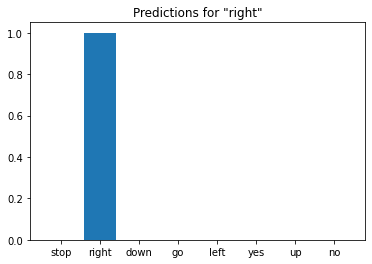

In [34]:
sample_file = data_dir/'right/012c8314_nohash_1.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

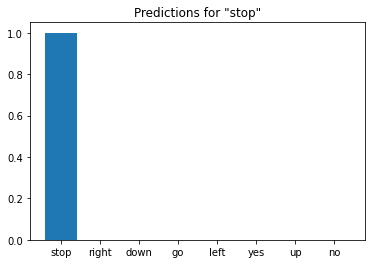

In [35]:
sample_file = data_dir/'stop/012c8314_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

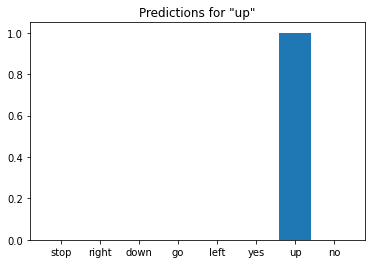

In [36]:
sample_file = data_dir/'up/0132a06d_nohash_2.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

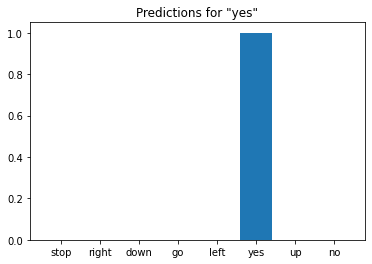

In [37]:
sample_file = data_dir/'yes/004ae714_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

I was impressed that it seems like every audio was correctly classified. This was certaintly not the case when the number of epochs was lower. 